In [1]:
# ipython magic

%reset -f
# %matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
# general imports

import sys
sys.path.append('..')

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [3]:
# notebook specific imports

import tifffile as tf
import ntpath
import time
import math
import csv

from random import randint
from scipy import stats

from utils.gsheets_importer import gsheet2df, split_df, path_conversion, path_finder
from utils.paq2py import *
from utils.parse_markpoints import ParseMarkpoints
from utils.utils_funcs import *
from utils.parse_metadata import *

In [4]:
# plotting parameters 

params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)
sns.set()
sns.set_style('whitegrid')

In [5]:
# import and index metadata from g sheets

sheet_ID = '1PgSXs6BVHe9dACWEydykucN74rirNfOY4Vr_AmLcCdY'
SHEET_NAME = '2019-06-11_J048'
df = gsheet2df(sheet_ID, HEADER_ROW=2, SHEET_NAME=SHEET_NAME)
df

# at this point we have lots of files that could be whisker stim or photostim, need to find out which is which

for_processing = split_df(df, 'analyse_me') # only files with TRUE in 'analyse_me' column

if not for_processing.shape[0]:
    raise Exception('ERROR: no files set for analysing')

stim = for_processing.loc[:,'stim'] # find out what stims have been carried out
photostim_idx = [i for i,stim in enumerate(stim) if stim=='p'] # row indices of all photostim exps (for artifact removal)
whisker_stim_idx = [i for i,stim in enumerate(stim) if stim=='w'] # '' for whisker stim (no artifact removal)

if ( len(photostim_idx) + len(whisker_stim_idx) ) != stim.shape[0]:
    raise Exception('ERROR: stim type is not defined for some files')

tiff_paths = for_processing.loc[:,'tiff_path']
paq_paths = for_processing.loc[:,'paq_path']
naparm_paths = for_processing.loc[:,'naparm_path']

if not all(tiff_paths) or not all(paq_paths) or not all(naparm_paths):
    raise Exception('ERROR: missing tiff, paq or naparm paths for some entries')
    
# below is information that will be later required for suite2p and stim removal
# try:
#     n_frames = [int(i) for i in list(for_processing.loc[:,'n_frames'])] # for stim removal
#     stim_dur = [int(i) for i in list(for_processing.loc[:,'total_stim_duration'])] # for stim removal
#     n_planes = [int(i) for i in list(for_processing.loc[:,'n_planes'])] # for s2p and stim removal
#     fps = [int(i) for i in list(for_processing.loc[:,'fps'])]
# except:
#     raise Exception('ERROR: metadata missing or in wrong format')

# TODO: update this to path_finder rather than conversion, to increase failsafe at this point
packerstation_path = r"P:" # the path to PackerStation on the local machine

tiffs_pstation = path_conversion(tiff_paths, packerstation_path) # convert paths (from Packer1 or PackerStation) to local PackerStation paths
paqs_pstation = path_conversion(paq_paths, packerstation_path)
naparm_pstation = path_conversion(naparm_paths, packerstation_path)

tiffs_pstation

['P:rlees\\Data\\2019-06-11\\J048\\2019-06-11_J048_t-003',
 'P:rlees\\Data\\2019-06-11\\J048\\2019-06-11_J048_t-004',
 'P:rlees\\Data\\2019-06-11\\J048\\2019-06-11_J048_t-005',
 'P:rlees\\Data\\2019-06-11\\J048\\2019-06-11_J048_t-006']

In [6]:
pv_values, naparm_xml, naparm_gpl = getMetadata(tiffs_pstation, naparm_pstation)

P:rlees\Data\2019-06-11\J048\2019-06-11_J048_t-003
P:rlees\Data\2019-06-11\J048\2019-06-11_J048_t-003\2019-06-11_J048_t-003_BACKUP.xml
P:rlees\Data\2019-06-11\J048\2019-06-11_J048_NAPARM\2019-06-11_J048_NAPARM_003\2019-06-11_J048_NAPARM_003.xml
P:rlees\Data\2019-06-11\J048\2019-06-11_J048_NAPARM\2019-06-11_J048_NAPARM_003\2019-06-11_J048_NAPARM_003.gpl
Number of frames: 9411 
Number of planes: 1
Frames per second: 29.873733883942098
Frame averaging: 1
Size (x): 512
Size (y): 512
Imaging laser power: 200.0
Pixel size (x,y): 0.91321643765821 0.990172879033902
Number of groups: 2 
Number of sequence reps: 15 
Number of shots: 1 
Numbers of trials: 20 
Inter-point delay: 5
Repetitions: 1
Single stim dur (ms): 10
P:rlees\Data\2019-06-11\J048\2019-06-11_J048_t-004
P:rlees\Data\2019-06-11\J048\2019-06-11_J048_t-004\2019-06-11_J048_t-004_BACKUP.xml
P:rlees\Data\2019-06-11\J048\2019-06-11_J048_NAPARM\2019-06-11_J048_NAPARM_002\2019-06-11_J048_NAPARM_002.xml
P:rlees\Data\2019-06-11\J048\2019-06-

In [7]:
fps = []
n_planes = []
stim_dur = []

for i,_ in enumerate(pv_values):
    # metadata for this notebook
    fps.append(pv_values[i][0])
    n_planes.append(pv_values[i][5])

    # calculating total stim dur
    single_shot = naparm_gpl[i]
    inter_stim = naparm_xml[i][4]
    
    n_shots = naparm_xml[i][2]    
    single_stim = single_shot*n_shots
    total_single_stim = single_stim + inter_stim 
    
    n_groups = naparm_xml[i][0]           
    total_multi_stim = total_single_stim * n_groups
    
    seq_reps = naparm_xml[i][1]
    total_stim = total_multi_stim * seq_reps

    stim_dur.append(total_stim - inter_stim)

In [37]:
# choose the file index/plane to be analysed

df_index = 3 # index from the pandas dataframe populated by Google sheets, index (row) of the file to be analysed
num_planes = n_planes[df_index]
plane = 0 # choose plane to analyse, zero-indexed

# the path to your paq file
paq_path = paqs_pstation[df_index]

# the path to the umbrella suite2p file
# s2p_folder = path_finder(tiffs_pstation[df_index], 'suite2p', is_folder=False)
# s2p_path = os.path.join(s2p_folder, 'plane' + str(plane))
s2p_path = os.path.join(tiffs_pstation[df_index], 'suite2p', 'plane' + str(plane))
# s2p_path = os.path.join(tiffs_pstation[df_index], 'Artifact_removed', 'suite2p', 'plane' + str(plane))
print(s2p_path)

# change this to the name of the paq channel that the stim times was recorded on
stim_name = 'markpoints2packio'

P:rlees\Data\2019-06-11\J048\2019-06-11_J048_t-006\suite2p\plane0


In [38]:
# import paq and s2p data

paq = paq_read(paq_path)
raw, stat = s2p_loader(s2p_path, subtract_neuropil=False)

ops = np.load(os.path.join(s2p_path, 'ops.npy')).item()
iscell = np.load(os.path.join(s2p_path, 'iscell.npy'))

#arr = dfof(raw)
arr = raw
num_units = arr.shape[0]

arr.shape

(718, 57007)

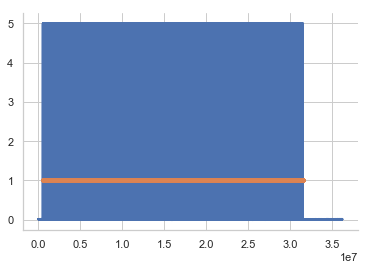

In [39]:
# find frame times

clock_idx = paq['chan_names'].index('frame_clock')
clock_voltage = paq['data'][clock_idx, :]

frame_clock = threshold_detect(clock_voltage, 1)
plt.figure()
plt.plot(clock_voltage)
plt.plot(frame_clock, np.ones(len(frame_clock)), '.')
sns.despine()
plt.show()

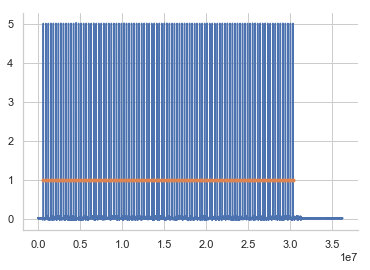

In [40]:
# find stim times

stim_idx = paq['chan_names'].index(stim_name)
stim_volts = paq['data'][stim_idx, :]
stim_times = threshold_detect(stim_volts, 1)

#correct this based on txt file
duration_ms = stim_dur[df_index]
frame_rate = fps[df_index]/num_planes
duration_frames = np.ceil((duration_ms/1000)*frame_rate)
duration_frames = int(duration_frames)

plt.figure()
plt.plot(stim_volts)
plt.plot(stim_times, np.ones(len(stim_times)), '.')
sns.despine()
plt.show()

In [41]:
# find stim frames

stim_start_frames = []

for stim in stim_times:

    #the index of the frame immediately preceeding stim
    stim_start_frame = next(i-1 for i,sample in enumerate(frame_clock[plane::num_planes]) if sample - stim >= 0)
    stim_start_frames.append(stim_start_frame)
    
stim_start_frames = np.array(stim_start_frames)

#sanity check
assert max(stim_start_frames) < arr.shape[1]*num_planes

In [42]:
#this is the key parameter for the sta, how many frames before and after the stim onset do you want to use
pre_frames = 30
post_frames = 100

#list of cell pixel intensity values during each stim on each trial
all_trials = [] # list 1 = cells, list 2 = trials, list 3 = dff vector

# the average of every trial
stas = [] # list 1 = cells, list 2 = sta vector

sta_amplitudes = []

t_tests = []
wilcoxons = []

#loop through each cell
for i, unit in enumerate(arr):

    trials = []
    amplitudes = []
    df = []
    
    # a flat list of all observations before stim occured
    pre_obs = []
    # a flat list of all observations after stim occured
    post_obs = []
    
    for stim in stim_start_frames:
        
        # get baseline values from pre_stim
        pre_stim_f  = unit[stim-pre_frames : stim]
        baseline = np.mean(pre_stim_f)

        # the whole trial and dfof using baseline
        trial = unit[stim-pre_frames : stim+post_frames]
        trial = [((f-baseline)/ baseline) * 100 for f in trial] #dff calc
        trials.append(trial)
        
        #calc amplitude of response        
        pre_f = trial[: pre_frames]
        pre_f = np.mean(pre_f)
        
        avg_post_start = pre_frames + duration_frames + 1
        avg_post_end = avg_post_start + 10
        
        post_f = trial[avg_post_start : avg_post_end]
        post_f = np.mean(post_f)
        amplitude = post_f - pre_f
        amplitudes.append(amplitude)
        
        # append to flat lists
        pre_obs.append(pre_f)
        post_obs.append(post_f)

        
    trials = np.array(trials)
    all_trials.append(trials)
    
    #average amplitudes across trials
    all_amplitudes = np.array(amplitudes)
    sta_amplitude = np.mean(all_amplitudes,0)
    sta_amplitudes.append(sta_amplitude)

    #average across all trials
    sta = np.mean(trials, 0)        
    stas.append(sta)
    
    #remove nans from flat lists
    pre_obs = [x for x in pre_obs if ~np.isnan(x)]
    post_obs = [x for x in post_obs if ~np.isnan(x)]
    
    #t_test and man whit test pre and post stim (any other test could also be used here)
    t_test = stats.ttest_rel(pre_obs, post_obs)
    t_tests.append(t_test)
    
    wilcoxon = stats.wilcoxon(pre_obs, post_obs)
    wilcoxons.append(wilcoxon)

stas = np.array(stas)
all_trials = np.array(all_trials)   
t_tests = np.array(t_tests)
wilcoxons = np.array(wilcoxons)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in float_scalars
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:2778: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


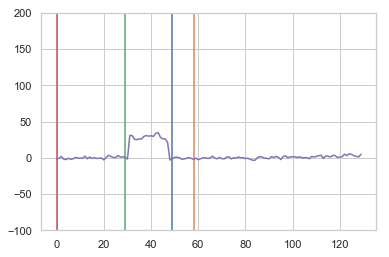

In [43]:
# plot the time bins used to make 'pre' and 'post' stim averages

plt.figure()
plt.plot([avg_post_start+1] * 2, [-1000, 1000])
plt.plot([avg_post_end] * 2, [-1000, 1000])
plt.plot([pre_frames-1] * 2, [-1000, 1000])
plt.plot([0] * 2, [-1000, 1000])
plt.plot(sta)
plt.ylim([-100,200]);

In [44]:
#set this to true if you want to multiple comparisons correct for the number of cells
multi_comp_correction = True
if not multi_comp_correction: 
    divisor = 1
else:
    divisor = num_units

In [45]:
p_vals = [t[1] for t in t_tests]
idx = range(len(p_vals))

if multi_comp_correction:
    print('performing t-test on cells with mutliple comparisons correction')
else:
    print('performing t-test on cells without mutliple comparisons correction')
    
count = 0
sig_units = []
for p,i in sorted(zip(p_vals,idx)):
    if p < (0.05 / divisor):
        count += 1
        unit_index = stat[i]['original_index']
        print('stimulation has significantly changed fluoresence of s2p unit {}, its P value is {}'.format(unit_index, p))
        sig_units.append(i) #significant units

performing t-test on cells with mutliple comparisons correction
stimulation has significantly changed fluoresence of s2p unit 155, its P value is 1.9307930614179086e-46
stimulation has significantly changed fluoresence of s2p unit 342, its P value is 2.839633693698976e-44
stimulation has significantly changed fluoresence of s2p unit 632, its P value is 3.555948235591325e-40
stimulation has significantly changed fluoresence of s2p unit 348, its P value is 1.1951916507874193e-39
stimulation has significantly changed fluoresence of s2p unit 85, its P value is 4.215171111602803e-39
stimulation has significantly changed fluoresence of s2p unit 799, its P value is 4.791134034886595e-39
stimulation has significantly changed fluoresence of s2p unit 370, its P value is 7.548244941552914e-36
stimulation has significantly changed fluoresence of s2p unit 406, its P value is 5.254730759836289e-35
stimulation has significantly changed fluoresence of s2p unit 868, its P value is 6.89997081597746e-35


In [46]:
# save the sta amplitudes from significantly different cells

# sig_amplitudes = [sta_amplitudes[i] for i in sig_units]
sig_amplitudes = [sta_amplitudes[i] for i in sig_units if stat[i]['med'][1] < 400]
# sig_amplitudes = [amplitude for amplitude in sta_amplitudes if ~np.isnan(amplitude)]

for item in os.listdir(tiffs_pstation[df_index]):
    if '.tif' in item or '.tiff' in item:
        filename = item
        base_path = os.path.splitext(filename)[0] # get parent folder of TIFF for saving files
        base_filename = os.path.basename(base_path)
        break

print(base_filename)

# np.save(os.path.join(s2p_path, base_filename + '_sig_sta_amplitudes.npy'), sig_amplitudes)
# np.save(os.path.join(s2p_path, base_filename + '_sig_sta_amplitudes_S1.npy'), sta_amplitudes)

2019-06-11_J048_t-006_Cycle00001_Ch3


In [36]:
len([amplitude for amplitude in sig_amplitudes if amplitude>0])

110

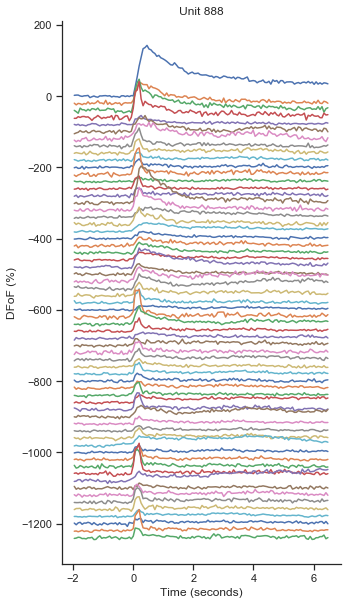

In [46]:
# Plot all units on same graph (good for 20-50 units)

plt.figure(figsize=(5,10))

for i,unit in enumerate(sig_units):
    line_offset = i*20
    
    unit_index = stat[unit]['original_index']
    
    x_axis = (np.arange(len(sta)) - pre_frames) / frame_rate

    sta = stas[unit]
#     [plt.plot(x_axis, t - line_offset, c='grey', alpha=0.2) for t in all_trials[unit,:,:]]
    plt.plot(x_axis, sta - line_offset)
    plt.title('Unit ' + str(unit_index))
    plt.xlabel('Time (seconds)')
    plt.ylabel('DFoF (%)')
    #plt.ylim((-100,200))
    sns.despine()

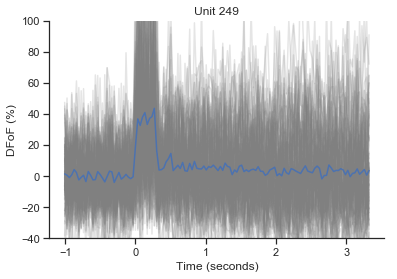

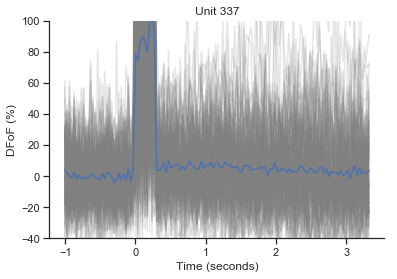

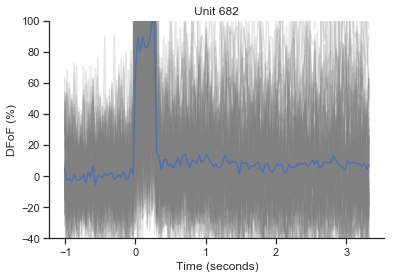

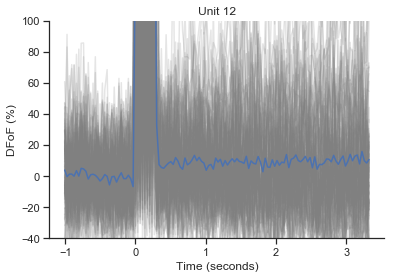

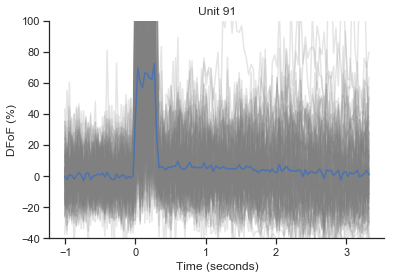

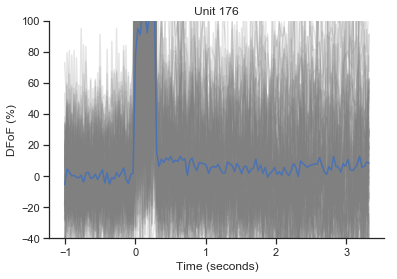

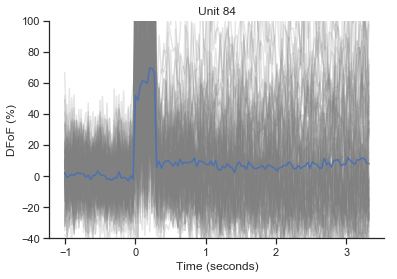

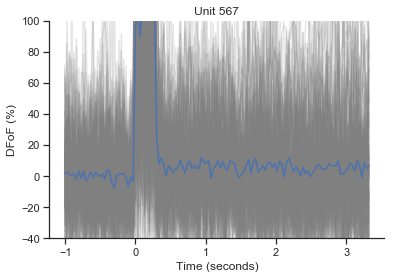

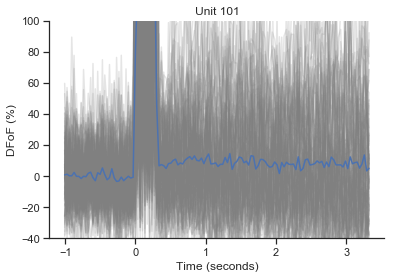

In [25]:
# Plot all units on individual graphs (good for 10-20 units)

for i,unit in enumerate(sig_units):
    if stat[unit]['med'][1] > 500:
        plt.figure()
        unit_index = stat[unit]['original_index']

        x_axis = (np.arange(len(sta)) - pre_frames) / frame_rate

        sta = stas[unit]
        [plt.plot(x_axis, t, c='grey', alpha=0.2) for t in all_trials[unit,:,:]]
        plt.plot(x_axis, sta)
        plt.title('Unit ' + str(unit_index))
        plt.xlabel('Time (seconds)')
        plt.ylabel('DFoF (%)')
        plt.ylim((-40,100))
        sns.despine()

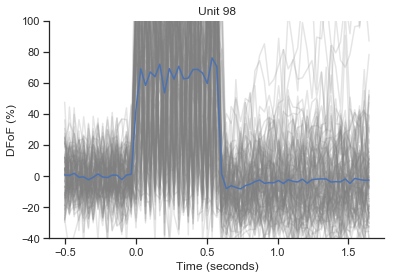

In [145]:
# Plot user-defined unit (good for visualising individual units of 100s)

plt.figure()
unit = 220
sig_unit = sig_units[unit]
unit_index = stat[sig_unit]['original_index']
    
x_axis = (np.arange(len(sta)) - pre_frames) / frame_rate

sta = stas[sig_unit]
[plt.plot(x_axis, t, c='grey', alpha=0.2) for t in all_trials[sig_unit,:,:]]
plt.plot(x_axis, sta)
plt.title('Unit ' + str(unit_index))
plt.xlabel('Time (seconds)')
plt.ylabel('DFoF (%)')
plt.ylim((-40,100))
sns.despine()

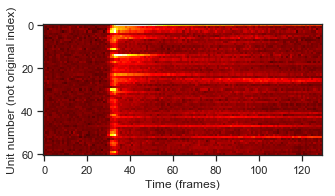

In [47]:
# Plot all units as a heatmap (good for visualising 100s of units)

plt.figure(figsize=(5,20))
sns.set_style('ticks')

heatmap_sta = []

for i in sig_units:
    if stat[i]['med'][1] < 500:
        heatmap_sta.append(stas[i])
#         print(stat[i]['original_index'])
    
plt.imshow(heatmap_sta, cmap='hot', vmin=-20, vmax=100, interpolation='nearest')

plt.xlabel('Time (frames)')
plt.ylabel('Unit number (not original index)')
plt.show()

15.926074955166765


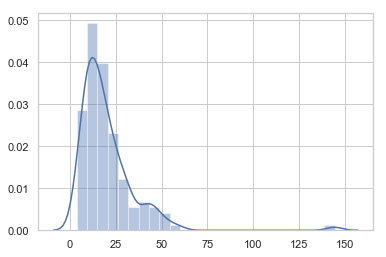

In [47]:
# for i,filename in enumerate(tiffs_pstation):
#     file = path_finder(filename, 'sig_sta_amplitudes.npy', is_folder=False)
#     print(file)
#     with open(file[0], 'rb') as f:
#         sig_amplitudes = np.load(f)
plt.figure()
# plt.boxplot(sig_amplitudes, notch=True);
sns.distplot(sig_amplitudes);
print(np.median(sig_amplitudes))

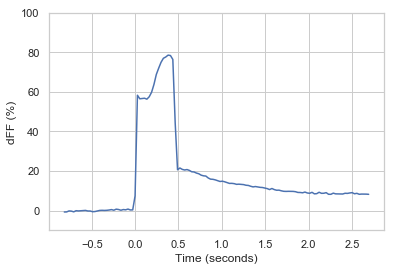

In [48]:
# Plot mean cell STA for S1

threshold = 400

clustered_units = []

for sig_unit in sig_units:
    if stat[sig_unit]['med'][1] < threshold:
        clustered_units.append(sig_unit)

a = np.mean(stas[clustered_units,:], axis = 0)
x_axis = (np.arange(len(sta)) - pre_frames) / frame_rate

plt.figure()
plt.plot(x_axis, a)
plt.xlabel('Time (seconds)')
plt.ylabel('dFF (%)')
plt.ylim((-10, 100))
plt.savefig(os.path.join(s2p_path, base_filename + '_sig_sta_amplitudes_S1.png'))

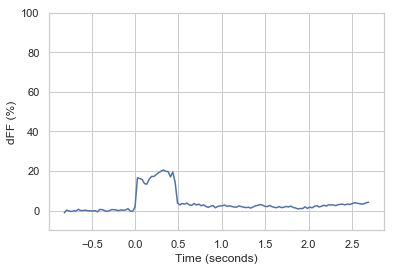

In [49]:
# Plot mean cell STA for S2 

clustered_units = []

for sig_unit in sig_units:
    if stat[sig_unit]['med'][1] > (threshold + 50):
        clustered_units.append(sig_unit)

a = np.mean(stas[clustered_units,:], axis = 0)
x_axis = (np.arange(len(sta)) - pre_frames) / frame_rate

plt.figure()
plt.plot(x_axis, a)
plt.xlabel('Time (seconds)')
plt.ylabel('dFF (%)')
plt.ylim((-10, 100))
plt.savefig(os.path.join(s2p_path, base_filename + '_sig_sta_amplitudes_S2.png'))

In [50]:
# Plot all units on blank image in place with STA amplitude to signify their response

stat = np.load(os.path.join(s2p_path, 'stat.npy'))

im = np.zeros((ops['Ly'], ops['Lx']), dtype='int32')

count = 0

for n in range(0,len(iscell)):
    if iscell[n][0] == 1:
        ypix = stat[n]['ypix']
        xpix = stat[n]['xpix']
        if math.isnan(sta_amplitudes[count]):
            im[ypix,xpix] = 0
        else:
            im[ypix,xpix] = sta_amplitudes[count]
        count += 1
        
tf.imwrite(os.path.join(s2p_path, 'cell_sta_image.tif'), im)

im = np.zeros((ops['Ly'], ops['Lx']), dtype='int32')

count = 0

for n in range(0,len(iscell)):
    if iscell[n][0] == 1:
        if count in sig_units:
            ypix = stat[n]['ypix']
            xpix = stat[n]['xpix']
            if math.isnan(sta_amplitudes[count]):
                im[ypix,xpix] = 0
            else:
                im[ypix,xpix] = sta_amplitudes[count]
        count += 1
        
tf.imwrite(os.path.join(s2p_path, 'cell_sig_sta_image.tif'), im)